In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from model_evaluation import evaluate_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import *
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree

from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout

In [36]:
# notebook parameters
input_dataset_path = 'data/heart.csv'

#### Functions

In [37]:
heart_df = pd.read_csv(input_dataset_path)
heart_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


In [38]:
# general dataset descriptors
print(f"Input dataset has {heart_df.shape[0]} rows and {heart_df.shape[1]} colums")
print(f"Input dataset consists of {heart_df.drop(columns=['target']).shape[1]} features and 1 target column")

print(f"Target values are: {heart_df['target'].unique()}")
print(f"Input dataset contains {heart_df[heart_df.duplicated()].shape[0]} duplicated rows and {heart_df[heart_df.duplicated()==False].shape[0]} unique rows")

Input dataset has 1025 rows and 14 colums
Input dataset consists of 13 features and 1 target column
Target values are: [0 1]
Input dataset contains 723 duplicated rows and 302 unique rows


In [39]:
# delete all duplicated values within the dataset
heart_df.drop_duplicates(inplace=True)

In [40]:
# divide a heart failure dataset into features and target value sets
x = heart_df.drop(columns=['target'])
y = heart_df['target']

In [41]:
# Select training and test datasets
x_train, x_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    random_state=12, 
                                                    test_size=0.25)

print(f"Training dataset consists of {x_train.shape[0]} records")
print(f"Test dataset consists of {x_test.shape[0]} records")

Training dataset consists of 226 records
Test dataset consists of 76 records


In [42]:
# some models are sensitive for feature value scale differences
# StandardScaler is used to transform those values into rescaled format, without information loss
standard_scaler = StandardScaler()
x_train = standard_scaler.fit_transform(x_train)
x_test = standard_scaler.transform(x_test)

In [43]:
# Transform target data sets into binary matrix representation of the target values
y_cat_train = to_categorical(y_train)
y_cat_test = to_categorical(y_test)

### Decision Tree

Model accuracy: 72.36842105263158%
Model precision: 72.72727272727273%
Model recall: 78.04878048780488%
Model F1-score: 0.7529411764705882
Model Matthews Correlation Coefficient (MCC): 0.4418067693151992
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.72      0.66      0.69        35
           1       0.73      0.78      0.75        41

    accuracy                           0.72        76
   macro avg       0.72      0.72      0.72        76
weighted avg       0.72      0.72      0.72        76



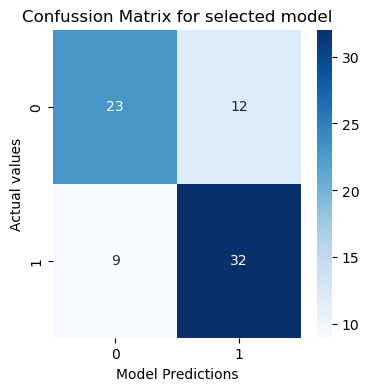

In [44]:
dt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')

dt_model.fit(x_train, y_train)
dt_acc, dt_mcc = evaluate_model(dt_model, x_test=x_test, y_test=y_test)

[Text(0.5640243902439024, 0.9444444444444444, 'x[2] <= -0.447\nentropy = 0.994\nsamples = 226\nvalue = [103, 123]'),
 Text(0.3719512195121951, 0.8333333333333334, 'x[12] <= 0.294\nentropy = 0.829\nsamples = 107\nvalue = [79, 28]'),
 Text(0.25609756097560976, 0.7222222222222222, 'x[11] <= -0.222\nentropy = 1.0\nsamples = 51\nvalue = [26, 25]'),
 Text(0.14634146341463414, 0.6111111111111112, 'x[8] <= 0.411\nentropy = 0.837\nsamples = 30\nvalue = [8, 22]'),
 Text(0.04878048780487805, 0.5, 'x[7] <= -2.24\nentropy = 0.469\nsamples = 20\nvalue = [2, 18]'),
 Text(0.024390243902439025, 0.3888888888888889, 'entropy = 0.0\nsamples = 1\nvalue = [1, 0]'),
 Text(0.07317073170731707, 0.3888888888888889, 'x[4] <= 1.327\nentropy = 0.297\nsamples = 19\nvalue = [1, 18]'),
 Text(0.04878048780487805, 0.2777777777777778, 'entropy = 0.0\nsamples = 17\nvalue = [0, 17]'),
 Text(0.0975609756097561, 0.2777777777777778, 'x[4] <= 2.185\nentropy = 1.0\nsamples = 2\nvalue = [1, 1]'),
 Text(0.07317073170731707, 0.16

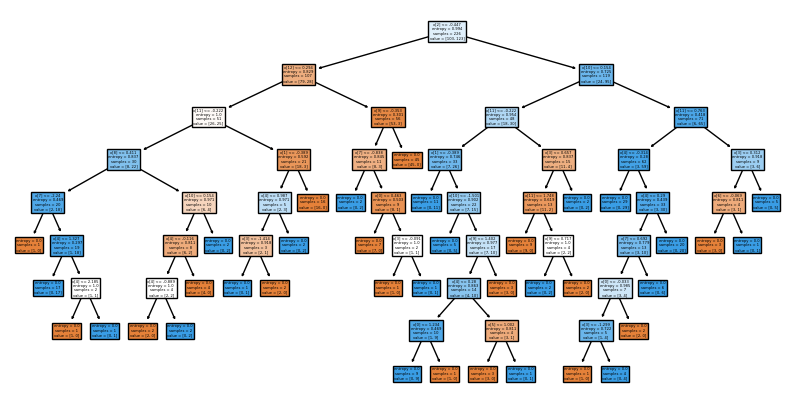

In [45]:
# this model is overfitted
plt.figure(figsize=(10,5))
tree.plot_tree(dt_model,filled=True)

### Pruning Decision Tree

In [46]:
base_pdt_model = DecisionTreeClassifier(random_state=11, 
                                  criterion='entropy')
ccp_path = base_pdt_model.cost_complexity_pruning_path(x_train, y_train)
ccp_alphas, impurities = ccp_path.ccp_alphas, ccp_path.impurities

In [47]:
pdt_models = []
for ccp_alpha in ccp_alphas:
    pdt_model = DecisionTreeClassifier(random_state=11,
                                       ccp_alpha=ccp_alpha)
    pdt_model.fit(x_train, y_train)

    # add Pruning Decision Tree classifier to list of trees
    pdt_models.append(pdt_model)

In [48]:
print(f"Last tree in list has {pdt_models[-1].tree_.node_count} for cpp_alpha parameter {ccp_alphas[-1]}")

Last tree in list has 1 for cpp_alpha parameter 0.21982887346468272


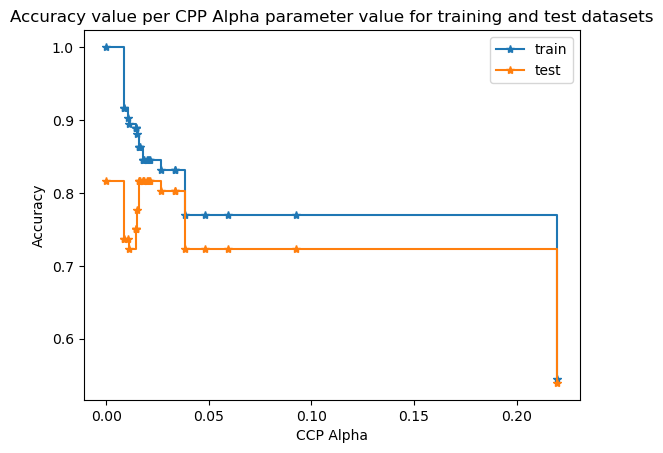

In [49]:
train_scores = [tree.score(x_train, y_train) for tree in pdt_models]
test_scores = [tree.score(x_test, y_test) for tree in pdt_models]

fig, ax = plt.subplots()
ax.set_xlabel("CCP Alpha")
ax.set_ylabel("Accuracy")
ax.set_title("Accuracy value per CPP Alpha parameter value for training and test datasets")
ax.plot(ccp_alphas, 
        train_scores, 
        marker='*', 
        label='train', 
        drawstyle="steps-post")
ax.plot(ccp_alphas, 
        test_scores, 
        marker='*', 
        label='test', 
        drawstyle="steps-post")
ax.legend()
plt.show()

Model accuracy: 72.36842105263158%
Model precision: 75.0%
Model recall: 73.17073170731707%
Model F1-score: 0.7407407407407408
Model Matthews Correlation Coefficient (MCC): 0.4452180646024972
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.69      0.71      0.70        35
           1       0.75      0.73      0.74        41

    accuracy                           0.72        76
   macro avg       0.72      0.72      0.72        76
weighted avg       0.72      0.72      0.72        76



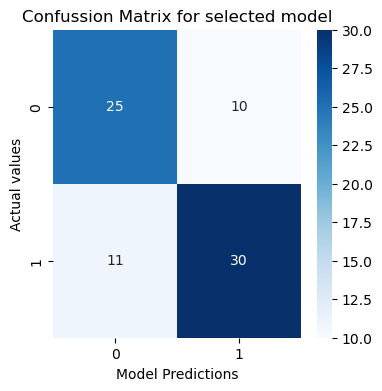

In [50]:
pdt_model = DecisionTreeClassifier(random_state=11,
                             ccp_alpha=0.09, 
                             criterion='entropy')
pdt_model.fit(x_train,y_train)
pdt_acc, pdt_mcc = evaluate_model(pdt_model, x_test=x_test, y_test=y_test)

[Text(0.6, 0.8333333333333334, 'x[2] <= -0.447\nentropy = 0.994\nsamples = 226\nvalue = [103, 123]'),
 Text(0.4, 0.5, 'x[12] <= 0.294\nentropy = 0.829\nsamples = 107\nvalue = [79, 28]'),
 Text(0.2, 0.16666666666666666, 'entropy = 1.0\nsamples = 51\nvalue = [26, 25]'),
 Text(0.6, 0.16666666666666666, 'entropy = 0.301\nsamples = 56\nvalue = [53, 3]'),
 Text(0.8, 0.5, 'entropy = 0.725\nsamples = 119\nvalue = [24, 95]')]

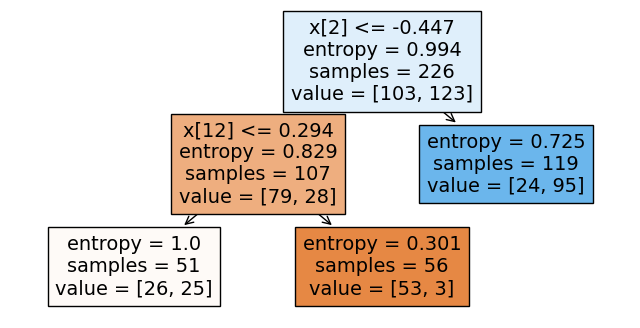

In [51]:
plt.figure(figsize=(8,4))
tree.plot_tree(pdt_model, filled=True)

### Random Forest

Model accuracy: 80.26315789473685%
Model precision: 79.54545454545455%
Model recall: 85.36585365853658%
Model F1-score: 0.8235294117647058
Model Matthews Correlation Coefficient (MCC): 0.6022079530793161
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.81      0.74      0.78        35
           1       0.80      0.85      0.82        41

    accuracy                           0.80        76
   macro avg       0.80      0.80      0.80        76
weighted avg       0.80      0.80      0.80        76



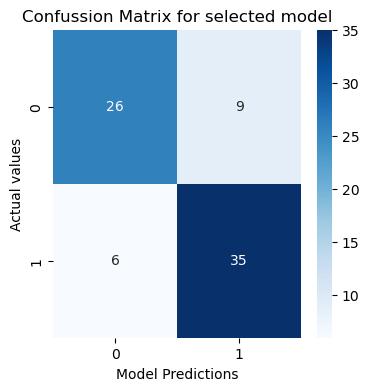

In [52]:
rf_model = RandomForestClassifier(n_estimators=100,
                                  criterion='entropy',
                                  max_features=0.5,
                                  min_samples_leaf=10,
                                  random_state=11,
                                  n_jobs=1)

rf_model.fit(x_train, y_train)
rf_acc, rf_mcc = evaluate_model(rf_model, x_test=x_test, y_test=y_test)

### CNN model

In [53]:
cnn_model = Sequential()
cnn_model.add(Dense(256, 
                    input_dim=13, 
                    activation='relu'))
cnn_model.add(Dense(256, 
                    activation='relu'))
cnn_model.add(Dense(2, 
                    activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])
print(f"CNN model summary: \n{cnn_model.summary()}")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 256)               3584      
                                                                 
 dense_4 (Dense)             (None, 256)               65792     
                                                                 
 dense_5 (Dense)             (None, 2)                 514       
                                                                 
Total params: 69890 (273.01 KB)
Trainable params: 69890 (273.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
CNN model summary: 
None


In [54]:
cnn_model.fit(x_train, 
              y_cat_train, 
              epochs=10, 
              validation_data=(x_test, y_cat_test))

Epoch 1/10
8/8 [==============================] - 1s 27ms/step - loss: 0.5811 - accuracy: 0.7257 - val_loss: 0.4229 - val_accuracy: 0.8026
Epoch 2/10
8/8 [==============================] - 0s 8ms/step - loss: 0.3605 - accuracy: 0.8673 - val_loss: 0.3905 - val_accuracy: 0.8553
Epoch 3/10
8/8 [==============================] - 0s 7ms/step - loss: 0.3285 - accuracy: 0.8496 - val_loss: 0.4196 - val_accuracy: 0.8289
Epoch 4/10
8/8 [==============================] - 0s 7ms/step - loss: 0.3088 - accuracy: 0.8717 - val_loss: 0.4151 - val_accuracy: 0.8289
Epoch 5/10
8/8 [==============================] - 0s 7ms/step - loss: 0.2804 - accuracy: 0.8850 - val_loss: 0.4147 - val_accuracy: 0.8684
Epoch 6/10
8/8 [==============================] - 0s 8ms/step - loss: 0.2668 - accuracy: 0.8894 - val_loss: 0.4138 - val_accuracy: 0.8289
Epoch 7/10
8/8 [==============================] - 0s 7ms/step - loss: 0.2454 - accuracy: 0.9115 - val_loss: 0.4170 - val_accuracy: 0.8026
Epoch 8/10
8/8 [=================

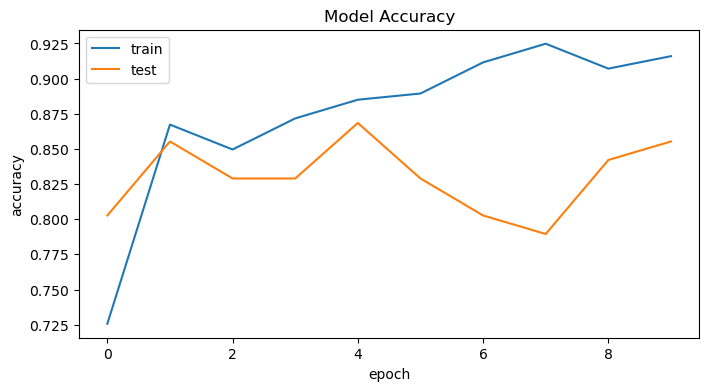

In [55]:
plt.figure(figsize=(8,4))
plt.plot(cnn_model.history.history['accuracy'])
plt.plot(cnn_model.history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

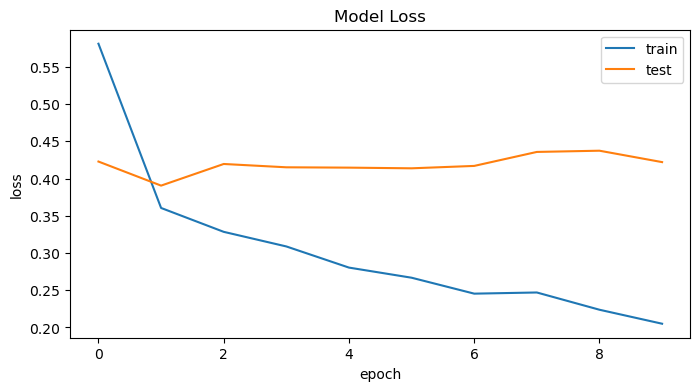

In [56]:
# Model Losss
plt.figure(figsize=(8,4))
plt.plot(cnn_model.history.history['loss'])
plt.plot(cnn_model.history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'])
plt.show()

In [57]:
print(f"CNN model evaluation after training: {cnn_model.evaluate(x_train, y_cat_train)}")
print (f"CNN model evaluation for test dataset: {cnn_model.evaluate(x_test, y_cat_test)}")

8/8 [==============================] - 0s 1ms/step - loss: 0.1879 - accuracy: 0.9292
CNN model evaluation after training: [0.18787023425102234, 0.9292035102844238]
3/3 [==============================] - 0s 2ms/step - loss: 0.4221 - accuracy: 0.8553
CNN model evaluation for test dataset: [0.42210283875465393, 0.8552631735801697]


3/3 [==============================] - 0s 2ms/step
Model accuracy: 85.52631578947368%
Model precision: 85.71428571428571%
Model recall: 87.8048780487805%
Model F1-score: 0.8674698795180722
Model Matthews Correlation Coefficient (MCC): 0.7083500040810027
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        35
           1       0.86      0.88      0.87        41

    accuracy                           0.86        76
   macro avg       0.86      0.85      0.85        76
weighted avg       0.86      0.86      0.86        76



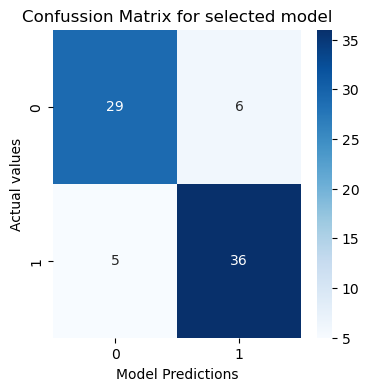

In [58]:
cnn_acc, cnn_mcc = evaluate_model(cnn_model, x_test=x_test, y_test=y_test, is_cnn=True)

### Logistic Regression

Model accuracy: 85.52631578947368%
Model precision: 82.6086956521739%
Model recall: 92.6829268292683%
Model F1-score: 0.8735632183908046
Model Matthews Correlation Coefficient (MCC): 0.7120364525153539
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.90      0.77      0.83        35
           1       0.83      0.93      0.87        41

    accuracy                           0.86        76
   macro avg       0.86      0.85      0.85        76
weighted avg       0.86      0.86      0.85        76



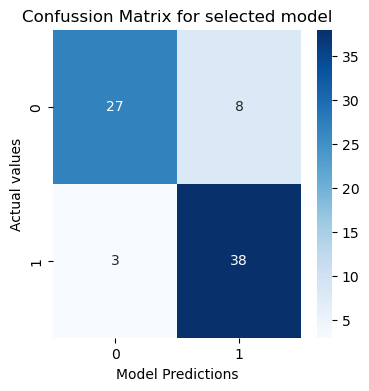

In [59]:
lr_model = LogisticRegression(random_state=0, C=10, penalty='l2')
lr_model.fit(x_train, y_train)
lr_acc, lr_mcc = evaluate_model(lr_model, x_test=x_test, y_test=y_test)

### Support Vector Machine

Model accuracy: 86.8421052631579%
Model precision: 82.97872340425532%
Model recall: 95.1219512195122%
Model F1-score: 0.8863636363636364
Model Matthews Correlation Coefficient (MCC): 0.7414892822055196
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.93      0.77      0.84        35
           1       0.83      0.95      0.89        41

    accuracy                           0.87        76
   macro avg       0.88      0.86      0.87        76
weighted avg       0.88      0.87      0.87        76



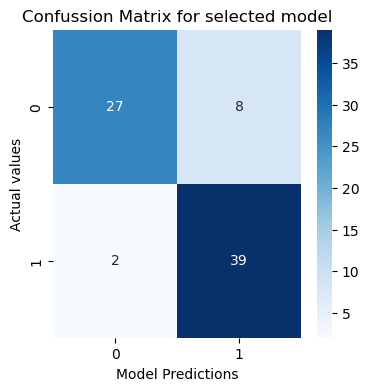

In [60]:
svm_model = SVC(kernel='linear', C=0.3)
svm_model.fit(x_train, y_train)
svm_acc, svm_mcc = evaluate_model(svm_model, x_test=x_test, y_test=y_test)

### K Nearest Neighbours

Model accuracy: 84.21052631578947%
Model precision: 83.72093023255815%
Model recall: 87.8048780487805%
Model F1-score: 0.8571428571428572
Model Matthews Correlation Coefficient (MCC): 0.6818607502596354
Model overall classification report:
 
              precision    recall  f1-score   support

           0       0.85      0.80      0.82        35
           1       0.84      0.88      0.86        41

    accuracy                           0.84        76
   macro avg       0.84      0.84      0.84        76
weighted avg       0.84      0.84      0.84        76



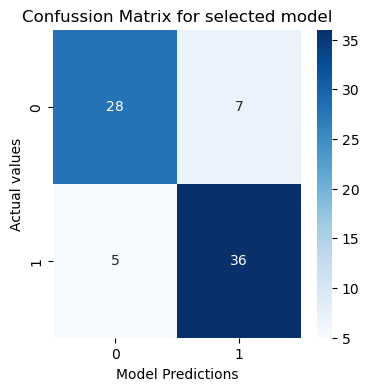

In [61]:
knn_model = KNeighborsClassifier(leaf_size=1, n_neighbors=3)
knn_model.fit(x_train, y_train)
knn_acc, knn_mcc = evaluate_model(knn_model, x_test=x_test, y_test=y_test)

### Comparison of models' results

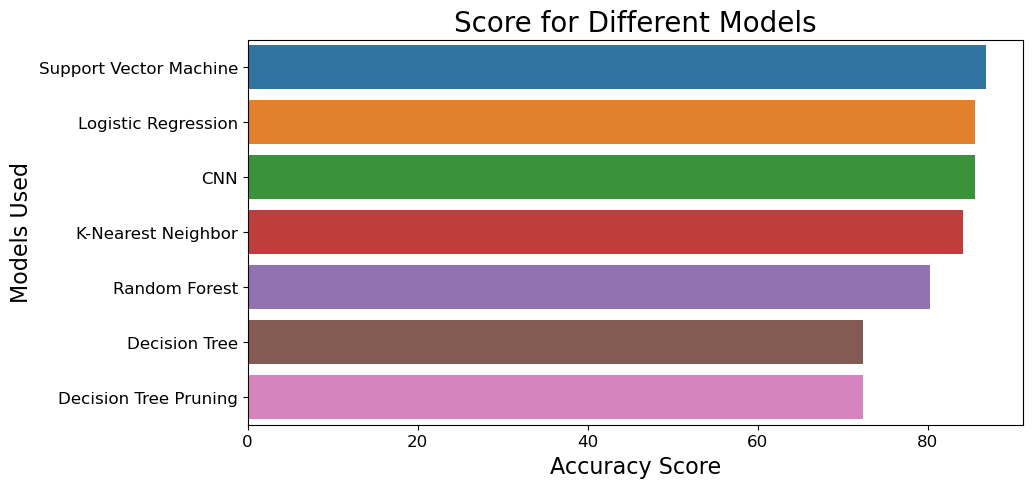

In [62]:
acc_scores = {
    'Decision Tree': dt_acc * 100, 
    'Decision Tree Pruning': pdt_acc * 100, 
    'Random Forest': rf_acc * 100, 
    'Logistic Regression': lr_acc * 100,
    'Support Vector Machine': svm_acc * 100, 
    'K-Nearest Neighbor': knn_acc * 100,
    'CNN': cnn_acc * 100
}

acc_scores = dict(sorted(acc_scores.items(), key = lambda x: x[1], reverse = True))
models = list(acc_scores.keys())
score = list(acc_scores.values())

fig = plt.figure(figsize=(10, 5))
sns.barplot(x=score, y=models)
plt.xlabel("Accuracy Score", size = 16)
plt.xticks(size = 12)
plt.ylabel("Models Used", size = 16)
plt.yticks(size = 12)
plt.title("Score for Different Models", size = 20)
plt.show()

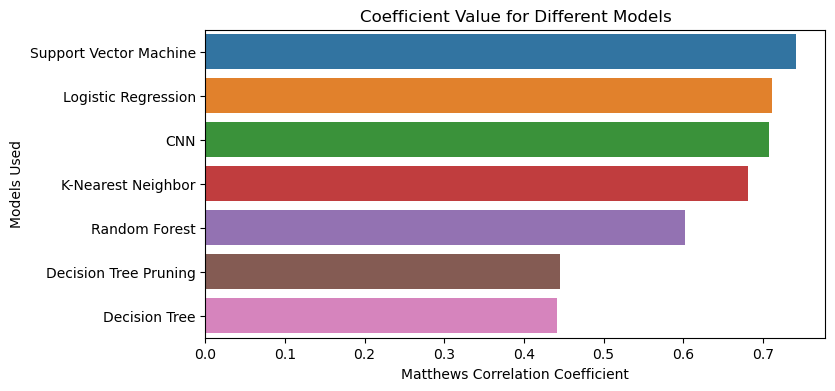

In [63]:
mcc_scores = {
    'Decision Tree': dt_mcc, 
    'Decision Tree Pruning': pdt_mcc, 
    'Random Forest': rf_mcc, 
    'Logistic Regression': lr_mcc,
    'Support Vector Machine': svm_mcc, 
    'K-Nearest Neighbor': knn_mcc,
    'CNN': cnn_mcc
}

mcc_scores = dict(sorted(mcc_scores.items(), key = lambda x: x[1], reverse = True))
models = list(mcc_scores.keys())
score = list(mcc_scores.values())

fig = plt.figure(figsize=(8, 4))
sns.barplot(x=score, y=models)
plt.xlabel("Matthews Correlation Coefficient")
plt.ylabel("Models Used")
plt.title("Coefficient Value for Different Models")
plt.show()